# Steel Plate Defect Prediction

In [37]:
#from google.colab import drive
#drive.mount('/content/drive')

In [38]:
#!pip install optuna
#!pip install catboost

In [77]:
%%time

import numpy as np
np.random.seed(42)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
sns.set_context("paper")

CPU times: user 673 µs, sys: 1e+03 ns, total: 674 µs
Wall time: 680 µs


In [78]:
#original_data = pd.read_csv('data/train.csv',index_col=0)
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)
df_org = pd.read_csv('data/original_data.csv')

In [79]:
# Print the first few rows of each dataset
print("Train data:\n", train.shape, "\n\nTest data:\n", test.shape, "\n\nSubmission data:\n", sub.shape, "\n\nOriginal data: \n", df_org.shape)

Train data:
 (19219, 34) 

Test data:
 (12814, 27) 

Submission data:
 (12814, 7) 

Original data: 
 (1941, 34)


In [80]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']

In [81]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [82]:
train.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [83]:
class Preprocess:

    def fit(self, X, y=None):
        return

    def fit_transform(self, X):
        epsilon = 1e-6

        # Location Features
        X['X_Distance'] = X['X_Maximum'] - X['X_Minimum']
        X['Y_Distance'] = X['Y_Maximum'] - X['Y_Minimum']

        # Density Feature
        X['Density'] = X['Pixels_Areas'] / (X['X_Perimeter'] + X['Y_Perimeter'])

        # Relative Perimeter Feature
        X['Relative_Perimeter'] = X['X_Perimeter'] / (X['X_Perimeter'] + X['Y_Perimeter'] + epsilon)

        # Circularity Feature
        X['Circularity'] = X['Pixels_Areas'] / (X['X_Perimeter'] ** 2)

        # Symmetry Index Feature
        X['Symmetry_Index'] = np.abs(X['X_Distance'] - X['Y_Distance']) / (X['X_Distance'] + X['Y_Distance'] + epsilon)

        # Color Contrast Feature
        X['Color_Contrast'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']

        # Combined Geometric Index Feature
        X['Combined_Geometric_Index'] = X['Edges_Index'] * X['Square_Index']

        # Interaction Term Feature
        X['X_Distance*Pixels_Areas'] = X['X_Distance'] * X['Pixels_Areas']

        # Additional Features
        X['sin_orientation'] = np.sin(X['Orientation_Index'])
        X['Edges_Index2'] = np.exp(X['Edges_Index'] + epsilon)
        X['X_Maximum2'] = np.sin(X['X_Maximum'])
        X['Y_Minimum2'] = np.sin(X['Y_Minimum'])
        X['Aspect_Ratio_Pixels'] = np.where(X['Y_Perimeter'] == 0, 0, X['X_Perimeter'] / X['Y_Perimeter'])
        X['Aspect_Ratio'] = np.where(X['Y_Distance'] == 0, 0, X['X_Distance'] / X['Y_Distance'])

        # Average Luminosity Feature
        X['Average_Luminosity'] = (X['Sum_of_Luminosity'] + X['Minimum_of_Luminosity']) / 2

        # Normalized Steel Thickness Feature
        X['Normalized_Steel_Thickness'] = (X['Steel_Plate_Thickness'] - X['Steel_Plate_Thickness'].min()) / (X['Steel_Plate_Thickness'].max() - X['Steel_Plate_Thickness'].min())

        # Logarithmic Features
        X['Log_Perimeter'] = np.log(X['X_Perimeter'] + X['Y_Perimeter'] + epsilon)
        X['Log_Luminosity'] = np.log(X['Sum_of_Luminosity'] + epsilon)
        X['Log_Aspect_Ratio'] = np.log(X['Aspect_Ratio'] ** 2 + epsilon)

        # Statistical Features
        X['Combined_Index'] = X['Orientation_Index'] * X['Luminosity_Index']
        X['Sigmoid_Areas'] = 1 / (1 + np.exp(-X['LogOfAreas'] + epsilon))

        return X


In [84]:
train = Preprocess().fit_transform(train)
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Y_Minimum2,Aspect_Ratio_Pixels,Aspect_Ratio,Average_Luminosity,Normalized_Steel_Thickness,Log_Perimeter,Log_Luminosity,Log_Aspect_Ratio,Combined_Index,Sigmoid_Areas
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.260085,1.600000,1.200000,1193.5,0.038462,2.564949,7.729296,0.364644,0.005200,0.769253
1,808,816,728350,728372,433,20,54,44478,70,111,...,-0.017598,0.370370,0.363636,22274.0,0.153846,4.304065,10.702750,-2.023194,-0.222347,0.933174
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.876624,1.678571,2.250000,655710.0,0.000000,7.025538,14.086599,1.621861,0.000991,0.982983
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,-0.997695,0.551724,0.296296,1658.0,0.000000,3.806663,8.071531,-2.432779,-0.026801,0.910699
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.071318,1.074627,0.444444,24156.5,1.000000,4.934474,10.783757,-1.621855,-0.224829,0.941000


In [85]:
df_org = Preprocess().fit_transform(df_org)
df_org.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Y_Minimum2,Aspect_Ratio_Pixels,Aspect_Ratio,Average_Luminosity,Normalized_Steel_Thickness,Log_Perimeter,Log_Luminosity,Log_Aspect_Ratio,Combined_Index,Sigmoid_Areas
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.448853,0.386364,0.181818,12148.0,0.153846,4.110874,10.094934,-3.409466,-0.238342,0.918826
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,-0.907991,0.333333,0.206897,5740.5,0.153846,3.688879,9.341105,-3.151049,-0.139268,0.884259
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,-0.396659,0.421053,0.333333,4035.5,0.230769,3.295837,8.983691,-2.197216,-0.081871,0.864280
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.375881,0.288889,0.155556,9547.5,0.961538,4.060443,9.851984,-3.721463,-0.132402,0.904262
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,-0.458158,0.230769,0.066148,123483.5,0.557692,5.768321,12.416860,-5.431497,-0.186013,0.967131


In [86]:
X, y = train.drop(targets, axis=1), np.argmax(train[targets].values, axis=1)

X_org, y_org  = df_org.drop(targets, axis=1), np.argmax(df_org[targets].values, axis=1)

X = pd.concat([X, X_org], axis=0)
y = np.concatenate([y, y_org])

In [87]:
def auc_score(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    return roc_auc_score(y, y_prob, multi_class="ovr")

In [88]:
# bests_xgb = {}

# splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42, train_size=0.25)

# for i, (train_index, test_index) in enumerate(splitter.split(X, y)):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     X_train = pd.concat([X_train, X_org], axis=0)
#     y_train = np.concatenate([y_train, y_org])


#     def objective(trial):
#         xgb_params = {
#             'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#             'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
#             'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000, 20000),
#             'min_child_samples': trial.suggest_int('min_child_samples', 20, 500, 5),
#             'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#             'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#             'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#             'max_depth': trial.suggest_int('max_depth', 3, 11),
#             'n_estimators': trial.suggest_int('n_estimators', 500, 3000, 50),
#             'boosting_type': trial.suggest_categorical('boosting_type', ['gbtree', 'dart']),
#         }

#         xgb = XGBClassifier(verbose=0, device='cuda', **xgb_params)
#         xgb.fit(X_train, y_train)

#         return auc_score(xgb, X_test, y_test)

#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=50, show_progress_bar=True)

#     bests_xgb[f'Best for fold {i} with value {study.best_value} is'] = study.best_params
# print(bests_xgb)

In [89]:
xgb1_best = {
    'num_leaves': 134,
    'learning_rate': 0.010271606426992659,
    'subsample_for_bin': 40000,
    'min_child_samples': 380,
    'reg_alpha': 0.16917262652846554,
    'reg_lambda': 0.13888617284516097,
    'colsample_bytree': 0.697112299518055,
    'subsample': 0.6205738758196828,
    'max_depth': 9,
    'n_estimators': 1250,
    'boosting_type': 'gbtree'
}

In [90]:
xgb1 = XGBClassifier(verbose=False, device='cuda', **xgb1_best)

In [91]:
# fit the model
xgb1.fit(X, y)

[10:56:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "boosting_type", "device", "min_child_samples", "num_leaves", "subsample_for_bin", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.697112299518055, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.010271606426992659, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_samples=380, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1250, n_jobs=0,
              num_leaves=134, num_parallel_tree=1, ...)

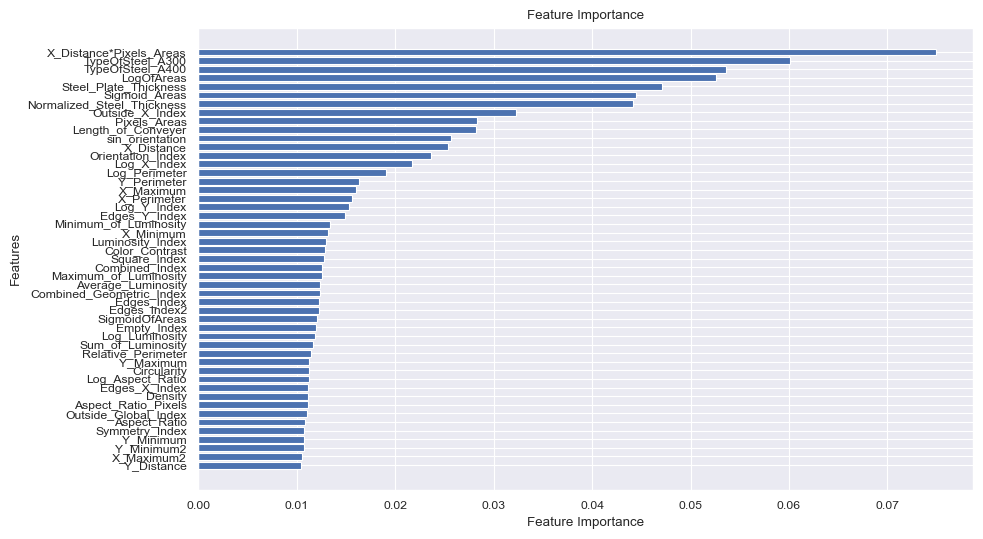

In [99]:
# Get feature importance from the xgb1 model
feature_importance = xgb1.feature_importances_

# Get the names of the features
feature_names = X.columns

# Pair feature names with their importance scores
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features based on importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1])

# Unpack the sorted features and importance scores
sorted_feature_names, sorted_feature_importance = zip(*sorted_features)

# Create a bar plot to show feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [ ]:
#lightgbm

bests_lgbm = {}

splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

for i, (train_index, test_index) in enumerate(splitter.split(X, y)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = np.concatenate([y_train, y_org])

    def objective(trial):
        lgbm_params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 10, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
            # Add more parameters as needed
        }

        lgbm = LGBMClassifier(**lgbm_params)
        lgbm.fit(X_train, y_train)
        y_pred = lgbm.predict_proba(X_test)[:, 1]

        return roc_auc_score(y_test, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    bests_lgbm[f'Best for fold {i} with value {study.best_value} is'] = study.best_params

print(bests_lgbm)


In [ ]:
#catboost

bests_catboost = {}

splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

for i, (train_index, test_index) in enumerate(splitter.split(X, y)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = np.concatenate([y_train, y_org])

    def objective(trial):
        catboost_params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'border_count': trial.suggest_int('border_count', 32, 255),
            # Add more parameters as needed
            'verbose': False
        }

        catboost = CatBoostClassifier(**catboost_params)
        catboost.fit(X_train, y_train, verbose=False)
        y_pred = catboost.predict_proba(X_test)[:, 1]

        return roc_auc_score(y_test, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    bests_catboost[f'Best for fold {i} with value {study.best_value} is'] = study.best_params

print(bests_catboost)

In [ ]:
sub.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
19222,0.5,0.5,0.5,0.5,0.5,0.5,0.5
19223,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
test = Preprocess().fit_transform(test)

In [ ]:
sub[targets] = xgb1.predict_proba(test)

In [ ]:
sub.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
19219,0.535738,0.000763,0.001535,0.000250,0.004063,0.127323,0.330328
19220,0.354974,0.011863,0.002443,0.000370,0.095484,0.100452,0.434413
19221,0.059615,0.008677,0.022776,0.000423,0.002515,0.343637,0.562357
19222,0.111677,0.000677,0.000367,0.000660,0.002931,0.431518,0.452170
19223,0.019485,0.000615,0.000356,0.001042,0.001133,0.701234,0.276135


In [ ]:
sub.to_csv('data/submission1.csv',index=True)